In [2]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
from glob import glob


In [3]:
low=glob("/Downloads/DeepLearning/LowLit_denoise/LOLdataset/eval15/low/*.png")
high=glob("/Downloads/DeepLearning/LowLit_denoise/LOLdataset/eval15/high/*.png")

In [4]:
low=np.sort(low)
high=np.sort(high)

In [5]:
from tensorflow.keras.models import load_model

new_model = load_model('CBDNet_lowLit_refined.h5')


In [8]:
def dim(limg,himg):
  limg=cv.imread(limg)
  himg=cv.imread(himg)
  limg=cv.cvtColor(limg,cv.COLOR_BGR2RGB)
  im=np.copy(himg)

  limg=cv.resize(limg,(512,512))
 

  im=cv.cvtColor(im,cv.COLOR_BGR2RGB)
  hsv=cv.cvtColor(im,cv.COLOR_RGB2HSV)
  hsv[...,2]=hsv[...,2]*0.15
  
  im=cv.cvtColor(hsv,cv.COLOR_HSV2RGB)
  im=cv.resize(im,(512,512))

  return limg,im


def check_pixel_range(image, x):
  """
  This function checks if 99.7% of pixels in an image lie within the range [0, x].

  Args:
      image: The input image as a NumPy array.
      x: The upper bound of the pixel range.

  Returns:
      True if 99.7% of pixels fall within the range, False otherwise.
  """

  # Flatten the image to a 1D array for easier processing
  flat_image = image.flatten()

  # Count the number of pixels within the range
  in_range = np.count_nonzero((flat_image >= 0) & (flat_image <= x))

  # Calculate the percentage of pixels in range
  total_pixels = flat_image.size
  percentage_in_range = (in_range / total_pixels) * 100

  # Check if 99.7% of pixels are within the range
  return percentage_in_range >= 99.7

def imgPrep(img,img1):
    hi=cv.imread(img1)
    hi=cv.cvtColor(hi,cv.COLOR_BGR2RGB)
    hi=cv.resize(hi,(512,512))
    l=img
    
    
    r,g,b=cv.split(l)
    xr=0
    xg=0
    xb=0
    for i in range(0,255,5):
        if(check_pixel_range(r,i)):
            xr=i
            break
    for i in range(0,255,5):
        if(check_pixel_range(g,i)):
            xg=i
            break
    for i in range(0,255,5):
        if(check_pixel_range(b,i)):
            xb=i
            break
    # print(xr,xg,xb)

    d=np.array(r,dtype='float64')
    d/=xr
    d=np.ceil(d*300)
    d=np.clip(d,0,255)
    d=np.array(d,dtype='uint8')
    r=d


    d=np.array(g,dtype='float64')
    d/=xg
    d=np.ceil(d*300)
    d=np.clip(d,0,255)
    d=np.array(d,dtype='uint8')
    g=d


    d=np.array(b,dtype='float64')
    d/=xb
    d=np.ceil(d*300)
    d=np.clip(d,0,255)
    d=np.array(d,dtype='uint8')
    b=d

    fin=cv.merge((r,g,b))
    # rgb=cv.cvtColor(hsv,cv.COLOR_HSV2RGB)

    return fin,hi



def processbef(x,y):
  xte1,_=dim(x,y)
  xte=tf.image.convert_image_dtype(xte1,tf.float32)
  # plt.imshow(xte)
  xte=tf.expand_dims(xte,axis=0)
  ypd=new_model.predict(xte,verbose=0)
  ypd=ypd[0]
  ypd=np.ceil(ypd*255)
  ypd=np.clip(ypd,0,255)
  ypd=ypd.astype('uint8')

  ypd,yte=imgPrep(ypd,y)

  #   using histogram equilization to get some normal light component
  hsv=cv.cvtColor(xte1,cv.COLOR_RGB2HSV)
  h,s,v=cv.split(hsv)
  v=cv.equalizeHist(v)
  hsv=cv.merge((h,s,v))
  rgb=cv.cvtColor(hsv,cv.COLOR_HSV2RGB)

  ypd=cv.addWeighted(ypd,0.7,rgb,0.3,5)
  ypd=cv.GaussianBlur(ypd,(3,3),1)

  return ypd,yte



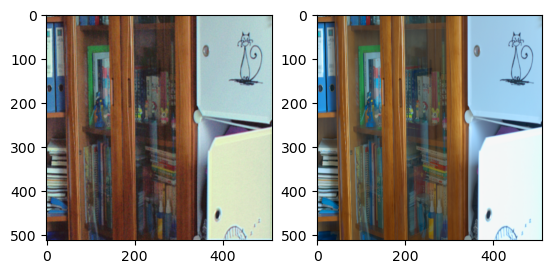

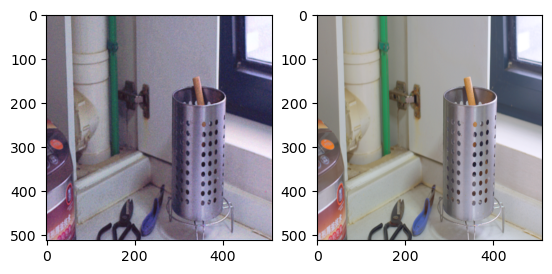

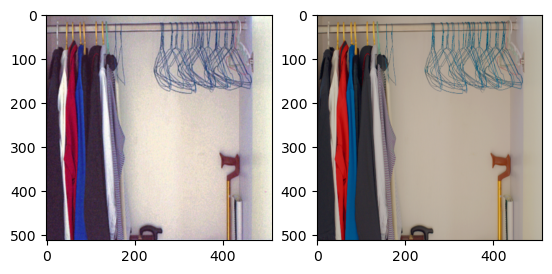

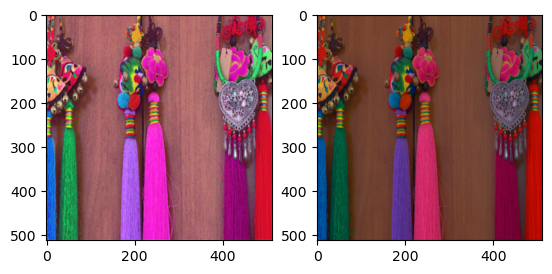

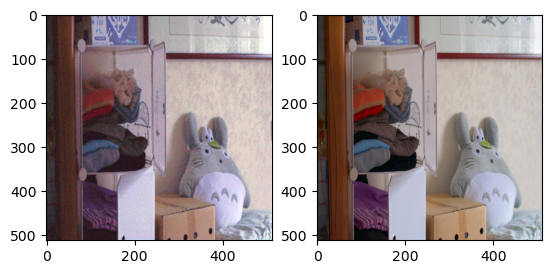

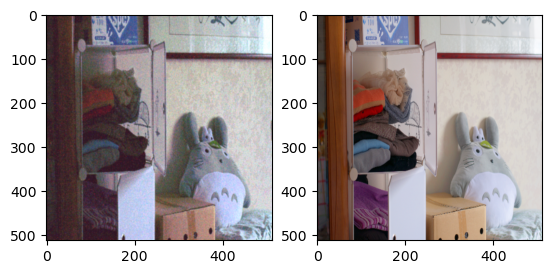

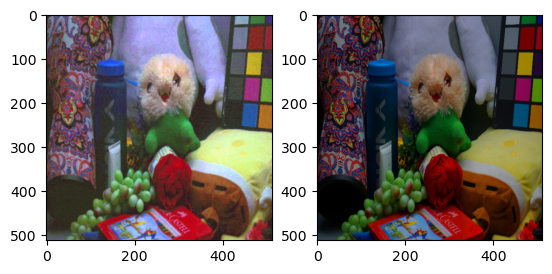

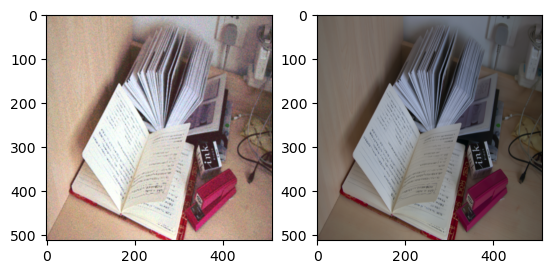

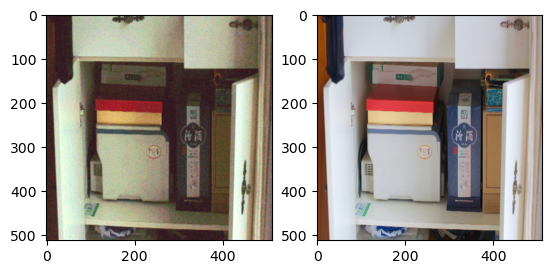

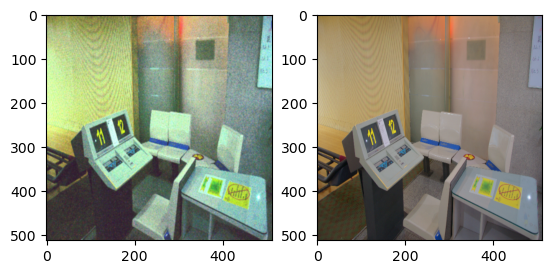

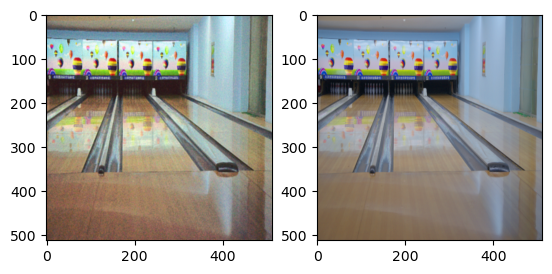

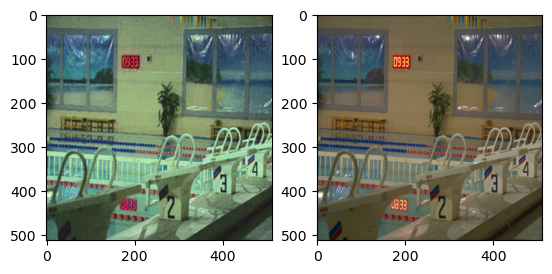

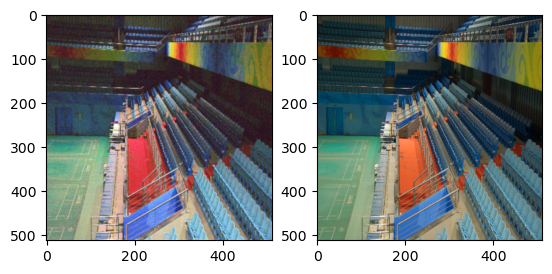

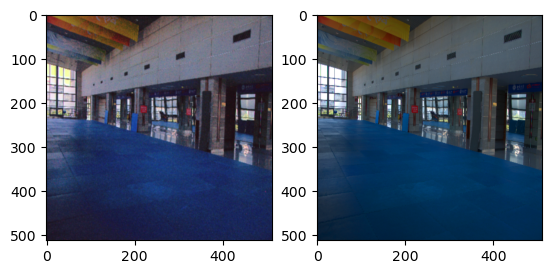

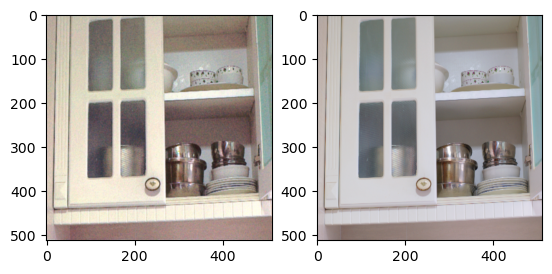

In [9]:
for i in range(15):
  ypd,yte=processbef(low[i],high[i])
  _,ax=plt.subplots(1,2)
  ax[0].imshow(ypd)
  ax[1].imshow(yte)